# Figures

This is the code for the figures in the paper

> C. Boulanger, N. Creutzfeldt & J. Hendry, The Journal of Law and Society in Context: A Bibliometric Analysis, Journal of Law and Society, forthcoming (2024)


## Fig. 1: Frequency analysis of "classic" authors in the sociolegal tradition

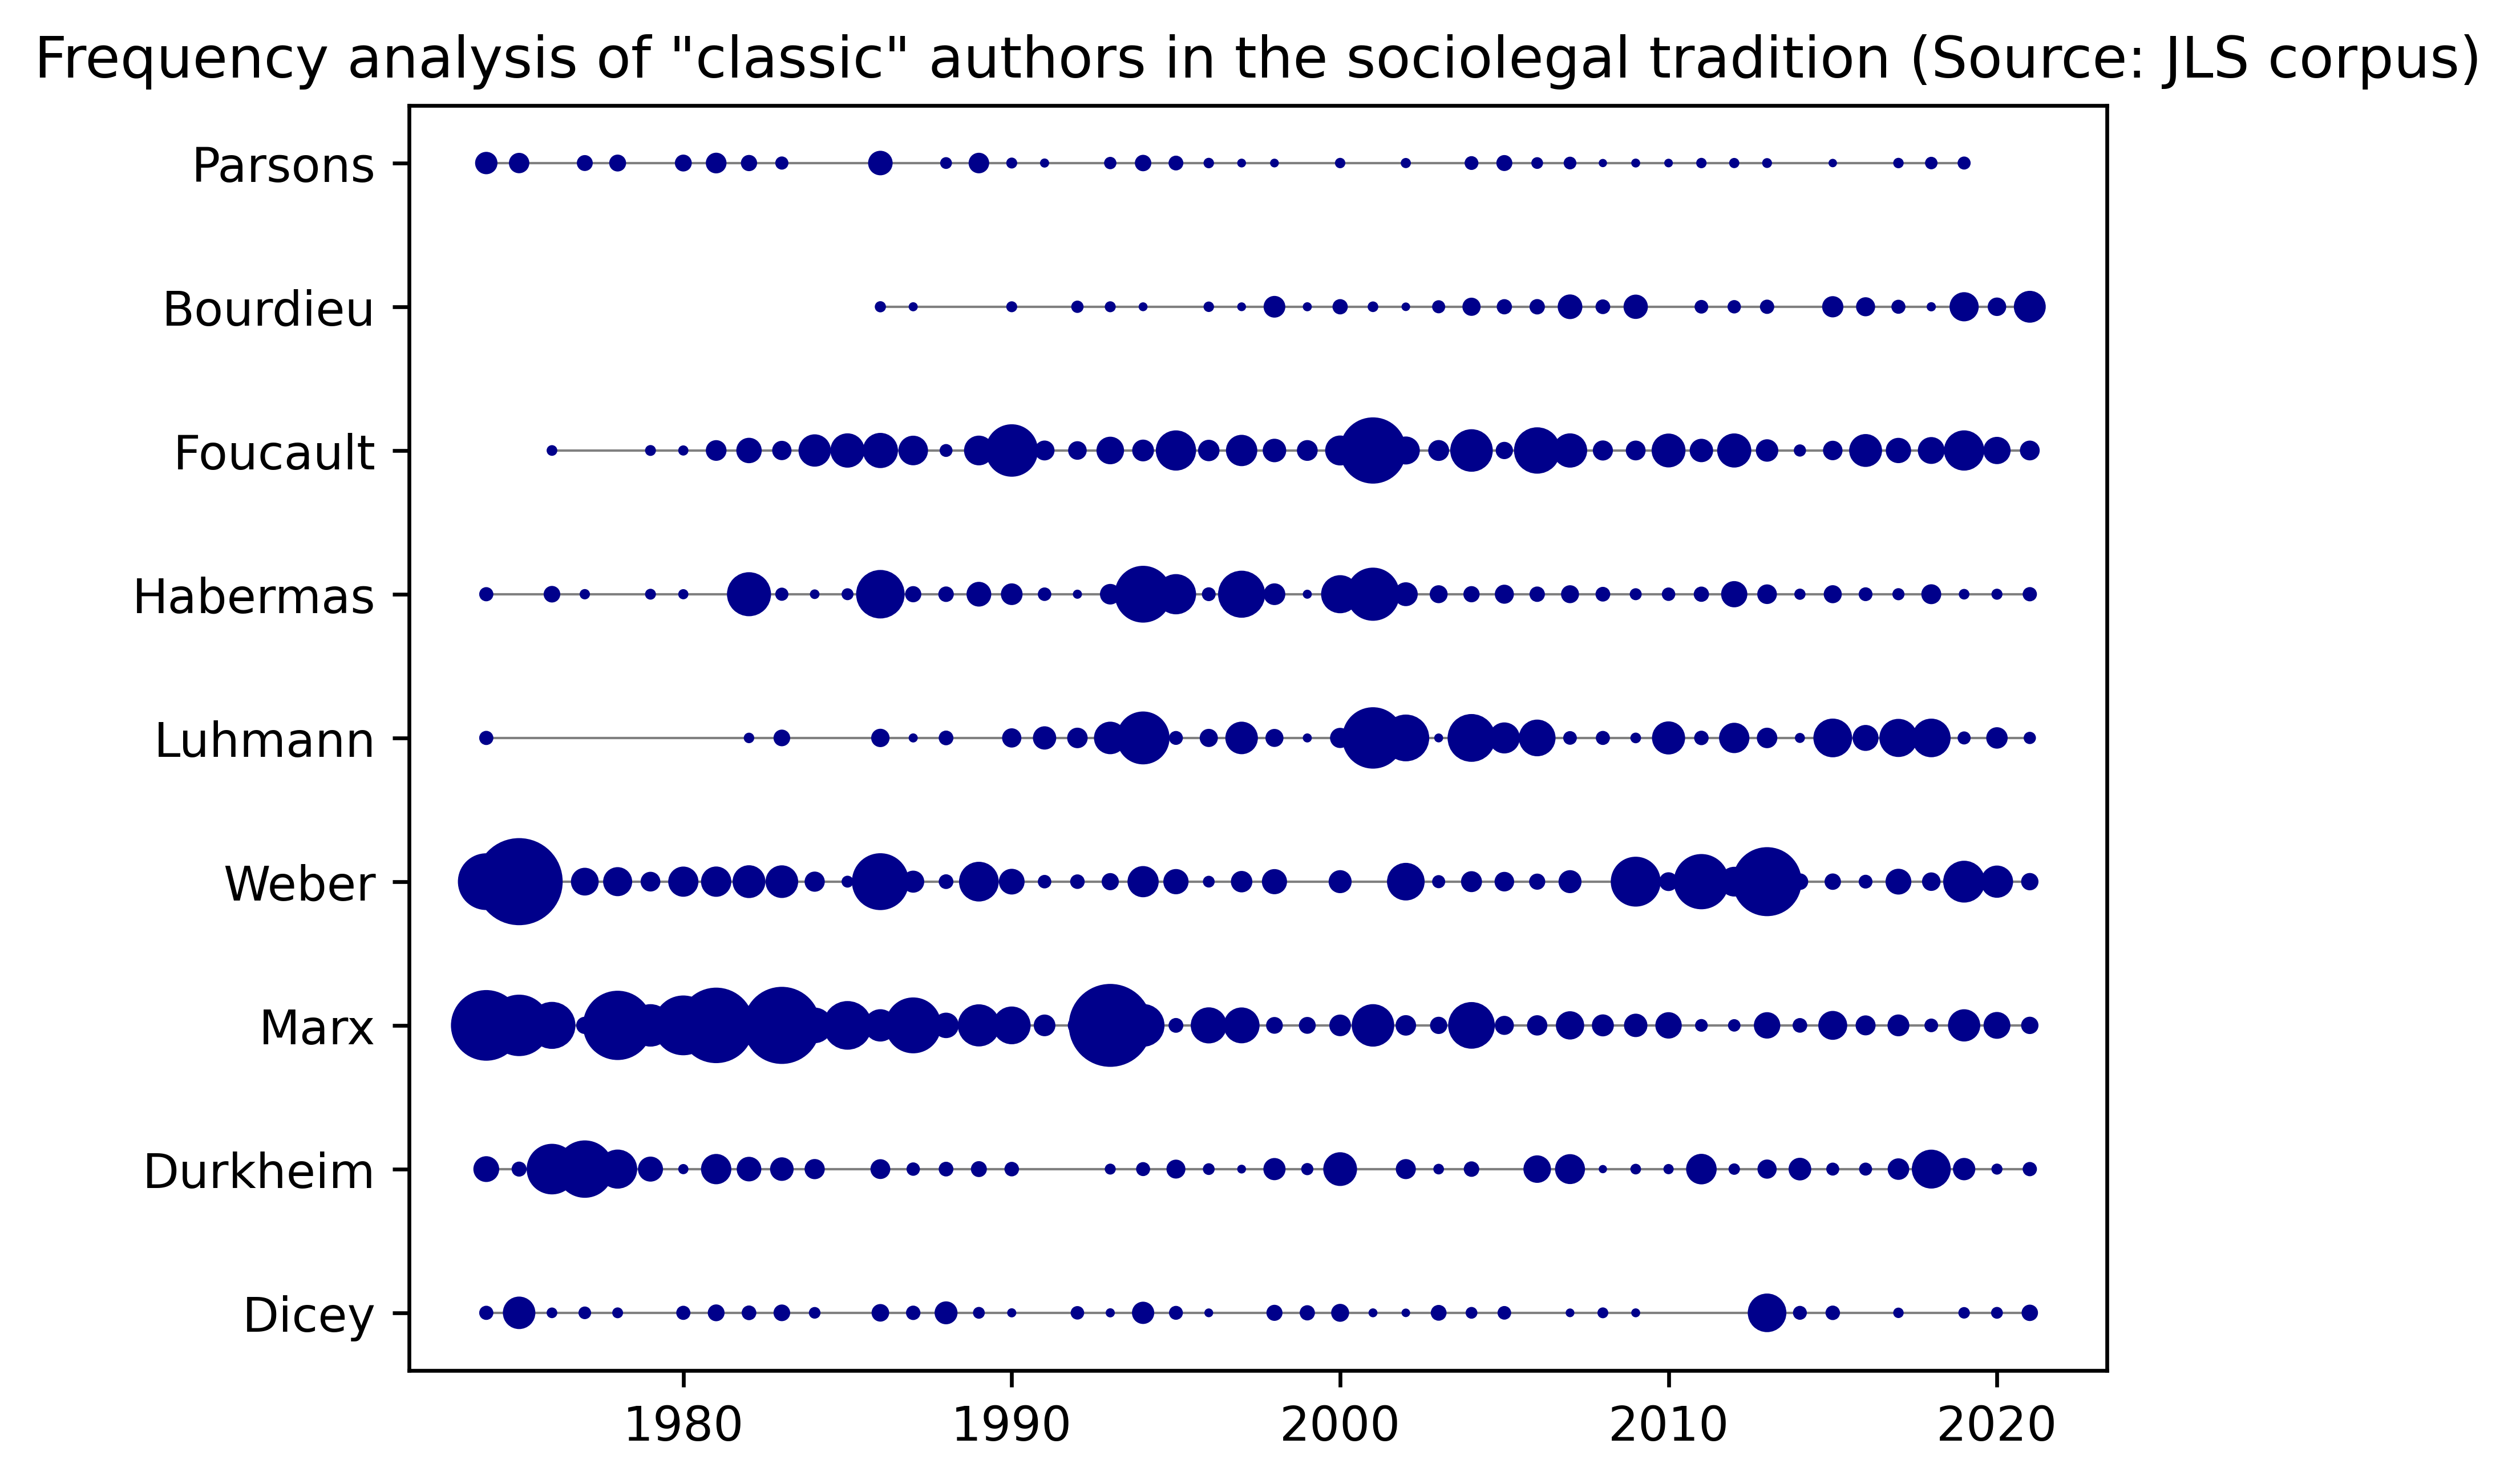

In [10]:
from scripts.utils import create_cached_corpus
from scripts.occurrence_by_year_scatter import prepare_data, plot_by_year
corpus = create_cached_corpus("jls3")
search_terms = ['Dicey', 'Durkheim', 'Marx', 'Weber', 'Luhmann', 'Habermas', 'Foucault', 'Bourdieu', 'Parsons']
data = prepare_data(corpus, search_terms)
plot_by_year(data,
             title='Frequency analysis of "classic" authors in the sociolegal tradition (Source: JLS corpus)',
             dpi=600, file="docs/article-fig-01.png")

## Fig 2: Number of citations of authors

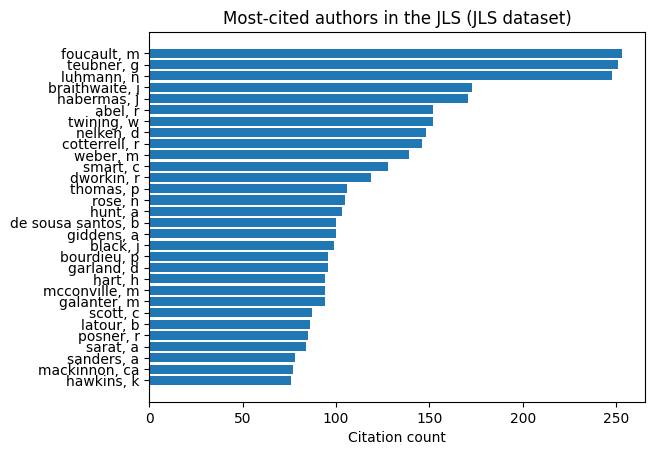

In [11]:
query = """
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
where citedAuthor.family <> "no_author"
return citedAuthor.display_name as `Author`, count(*) as `Citation count`
order by `Citation count` desc
limit 30
"""
import matplotlib.pyplot as plt
from scripts.utils import get_graph
graph = get_graph("jls3")
df = graph.run(query).to_data_frame()
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Author'], df['Citation count'])
plt.xlabel('Citation count')
plt.title('Most-cited authors in the JLS (JLS dataset)')
plt.savefig("docs/article-fig-02.png", bbox_inches="tight", dpi=600)
plt.show()

## Fig. 3: Frequency analysis of terms designating the JLS founding spirit

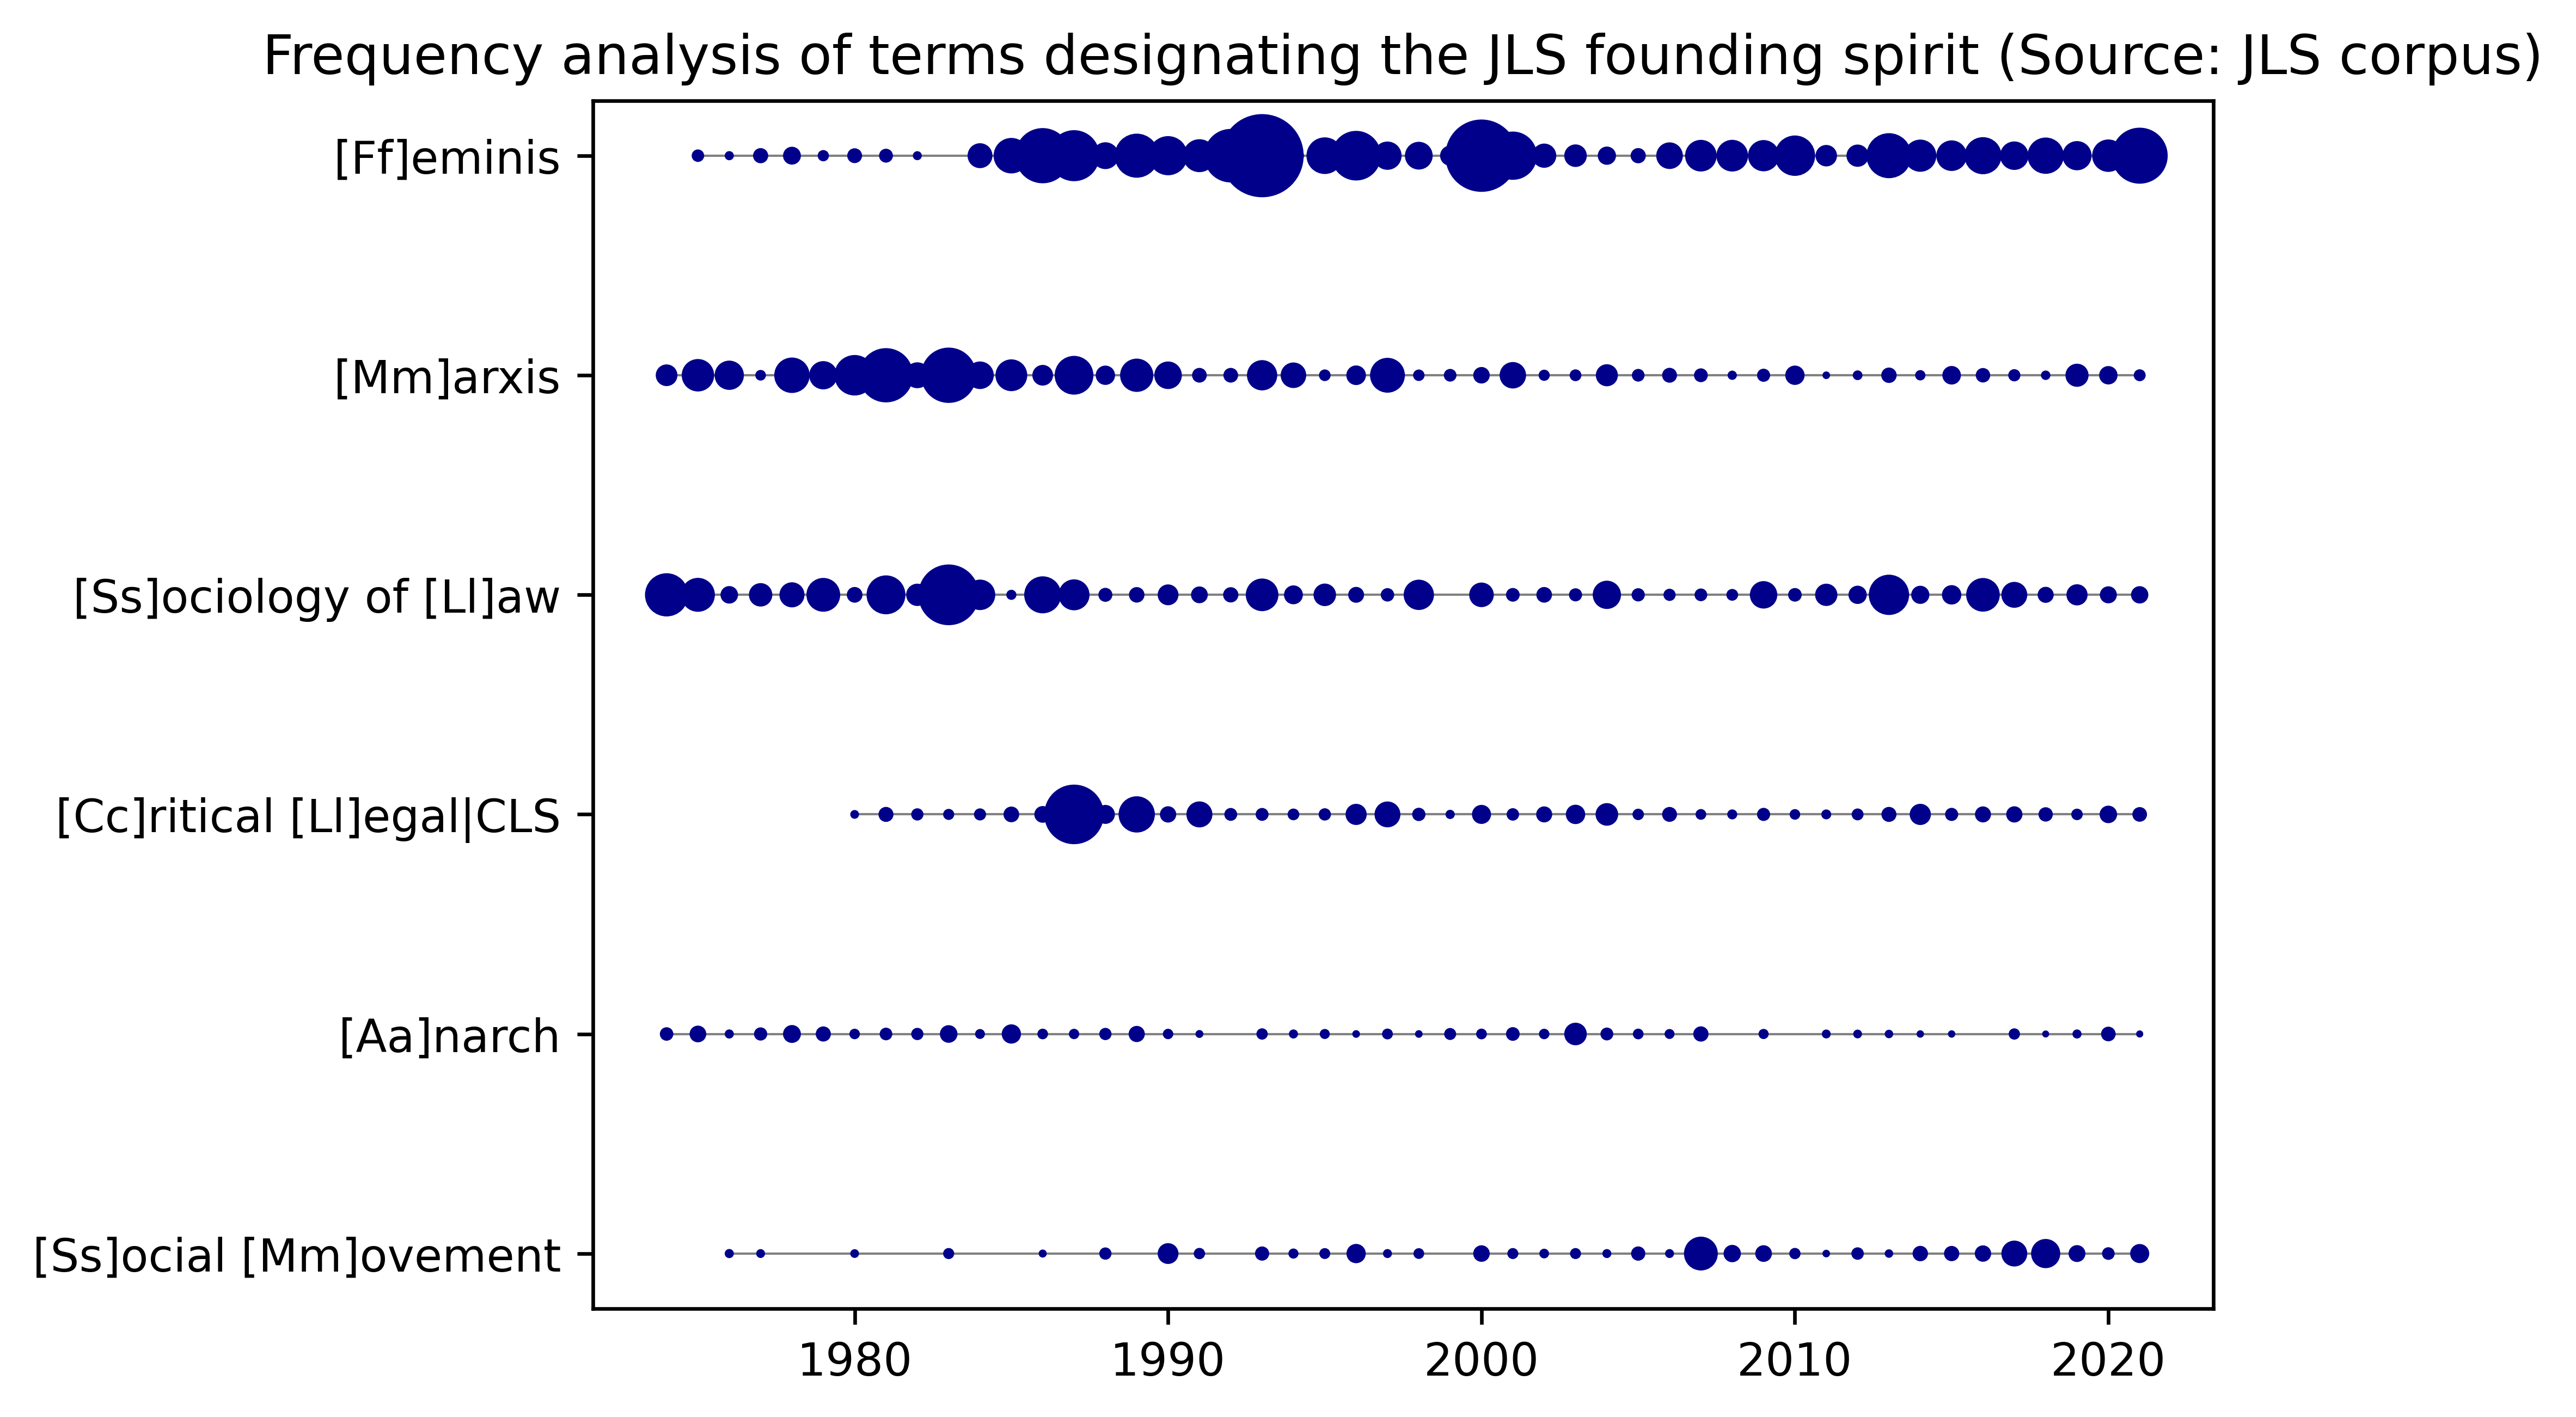

In [12]:
from scripts.utils import create_cached_corpus
from scripts.occurrence_by_year_scatter import prepare_data, plot_by_year
corpus = create_cached_corpus("jls3")
search_terms = ['[Ss]ocial [Mm]ovement', '[Aa]narch', '[Cc]ritical [Ll]egal|CLS', '[Ss]ociology of [Ll]aw', '[Mm]arxis', '[Ff]eminis']
data = prepare_data(corpus, search_terms)
plot_by_year(data,
             title='Frequency analysis of terms designating the JLS founding spirit (Source: JLS corpus)',
             dpi=600, file="docs/article-fig-03.png")

## Fig. 4: Frequency analysis of terms related to teaching, training and research evaluation (Source: JLS corpus)

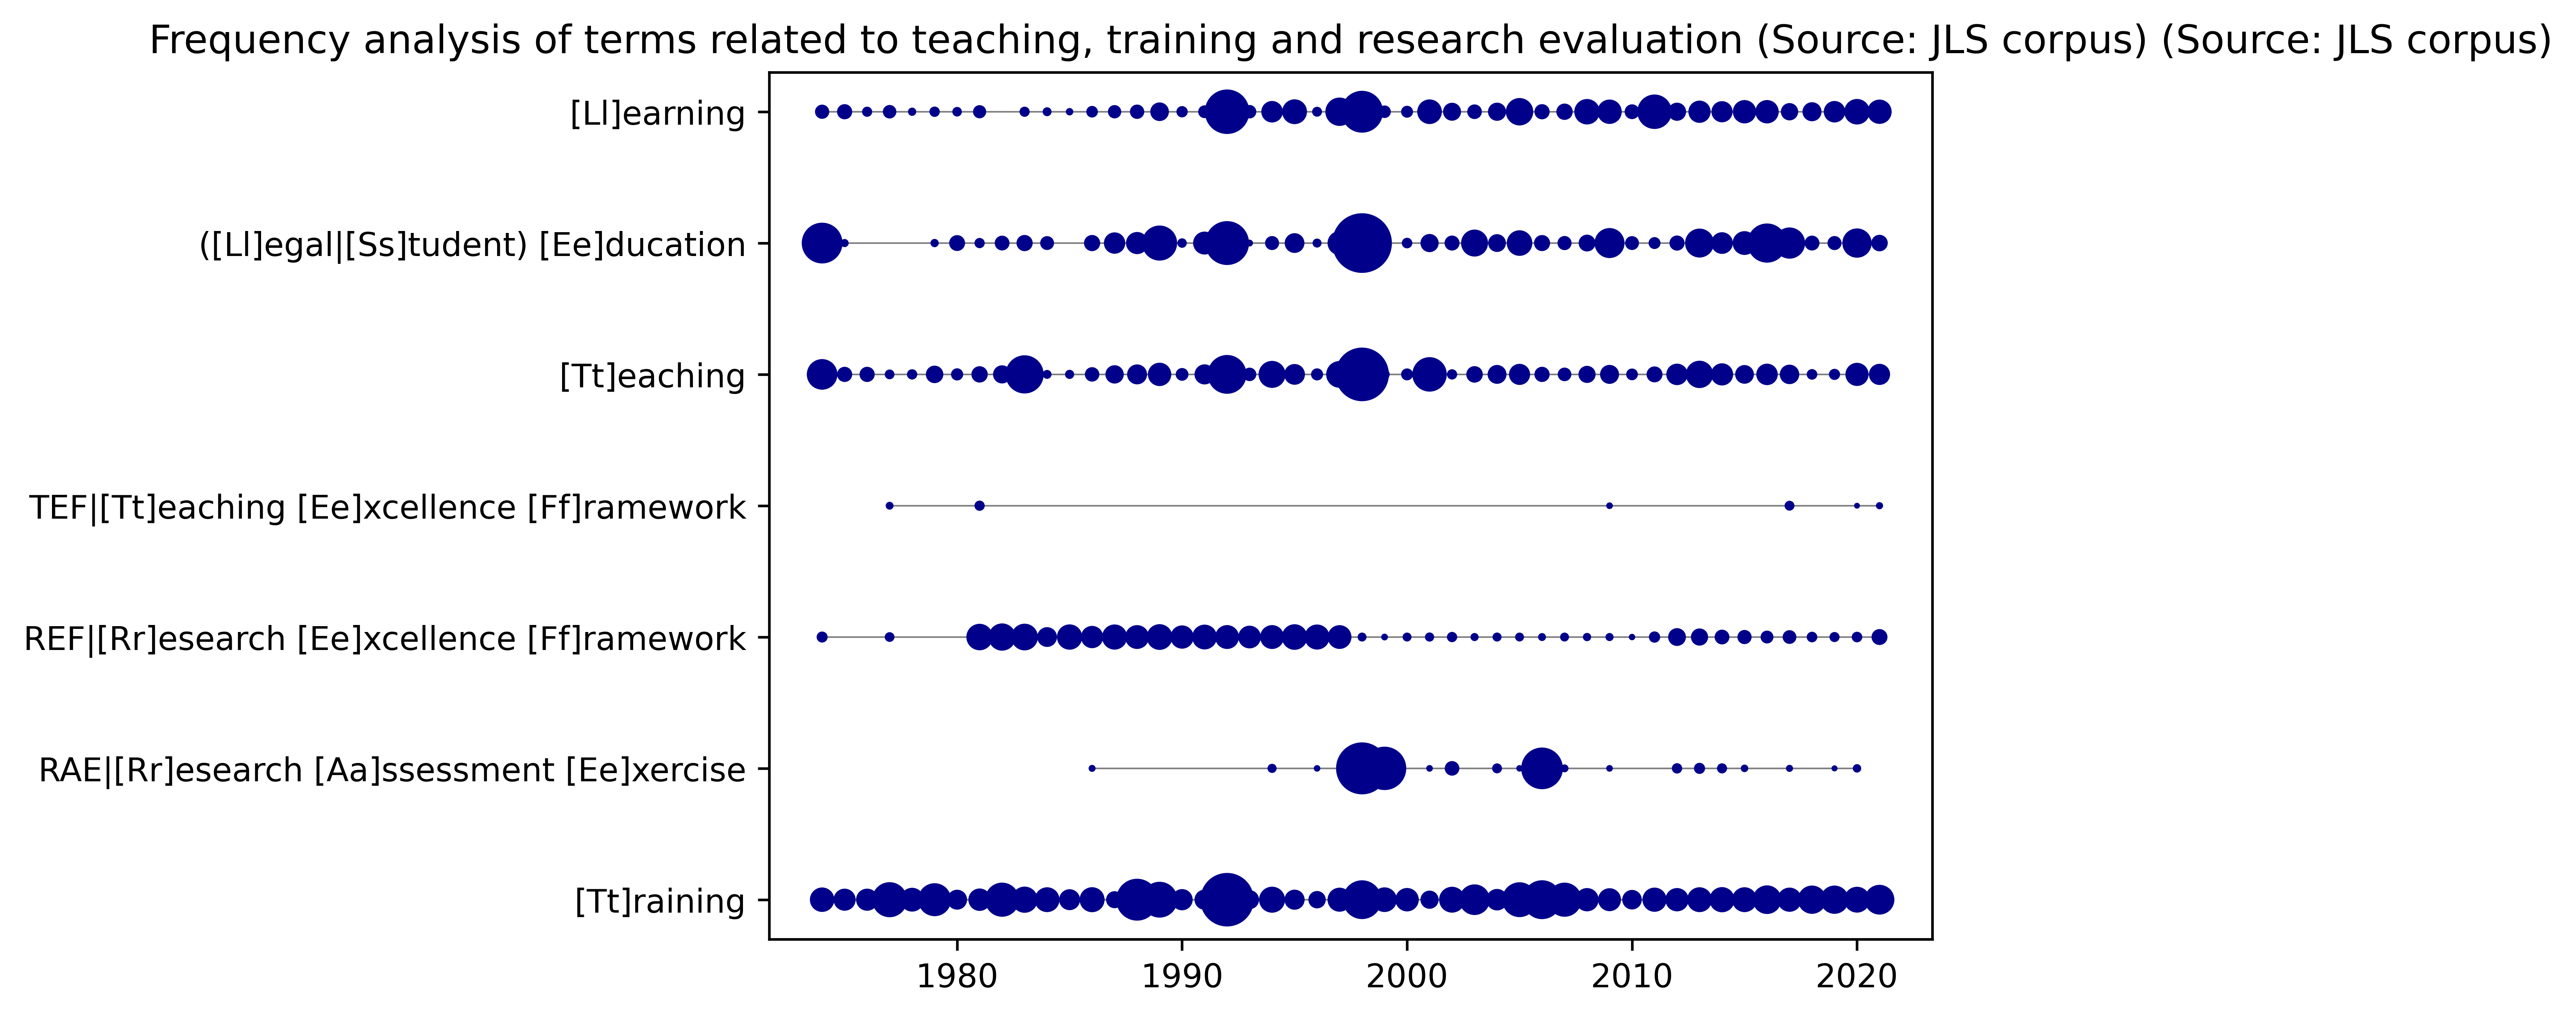

In [13]:

from scripts.utils import create_cached_corpus
from scripts.occurrence_by_year_scatter import prepare_data, plot_by_year
corpus = create_cached_corpus("jls3")
search_terms = [r'[Tt]raining',r'RAE|[Rr]esearch [Aa]ssessment [Ee]xercise',r'REF|[Rr]esearch [Ee]xcellence [Ff]ramework', r'TEF|[Tt]eaching [Ee]xcellence [Ff]ramework', r'[Tt]eaching',r'([Ll]egal|[Ss]tudent) [Ee]ducation', r'[Ll]earning']
data = prepare_data(corpus, search_terms)
plot_by_year(data,
             title='Frequency analysis of terms related to teaching, training and research evaluation (Source: JLS corpus) (Source: JLS corpus)',
             dpi=600, file="docs/article-fig-04.png")

# Fig. 5:

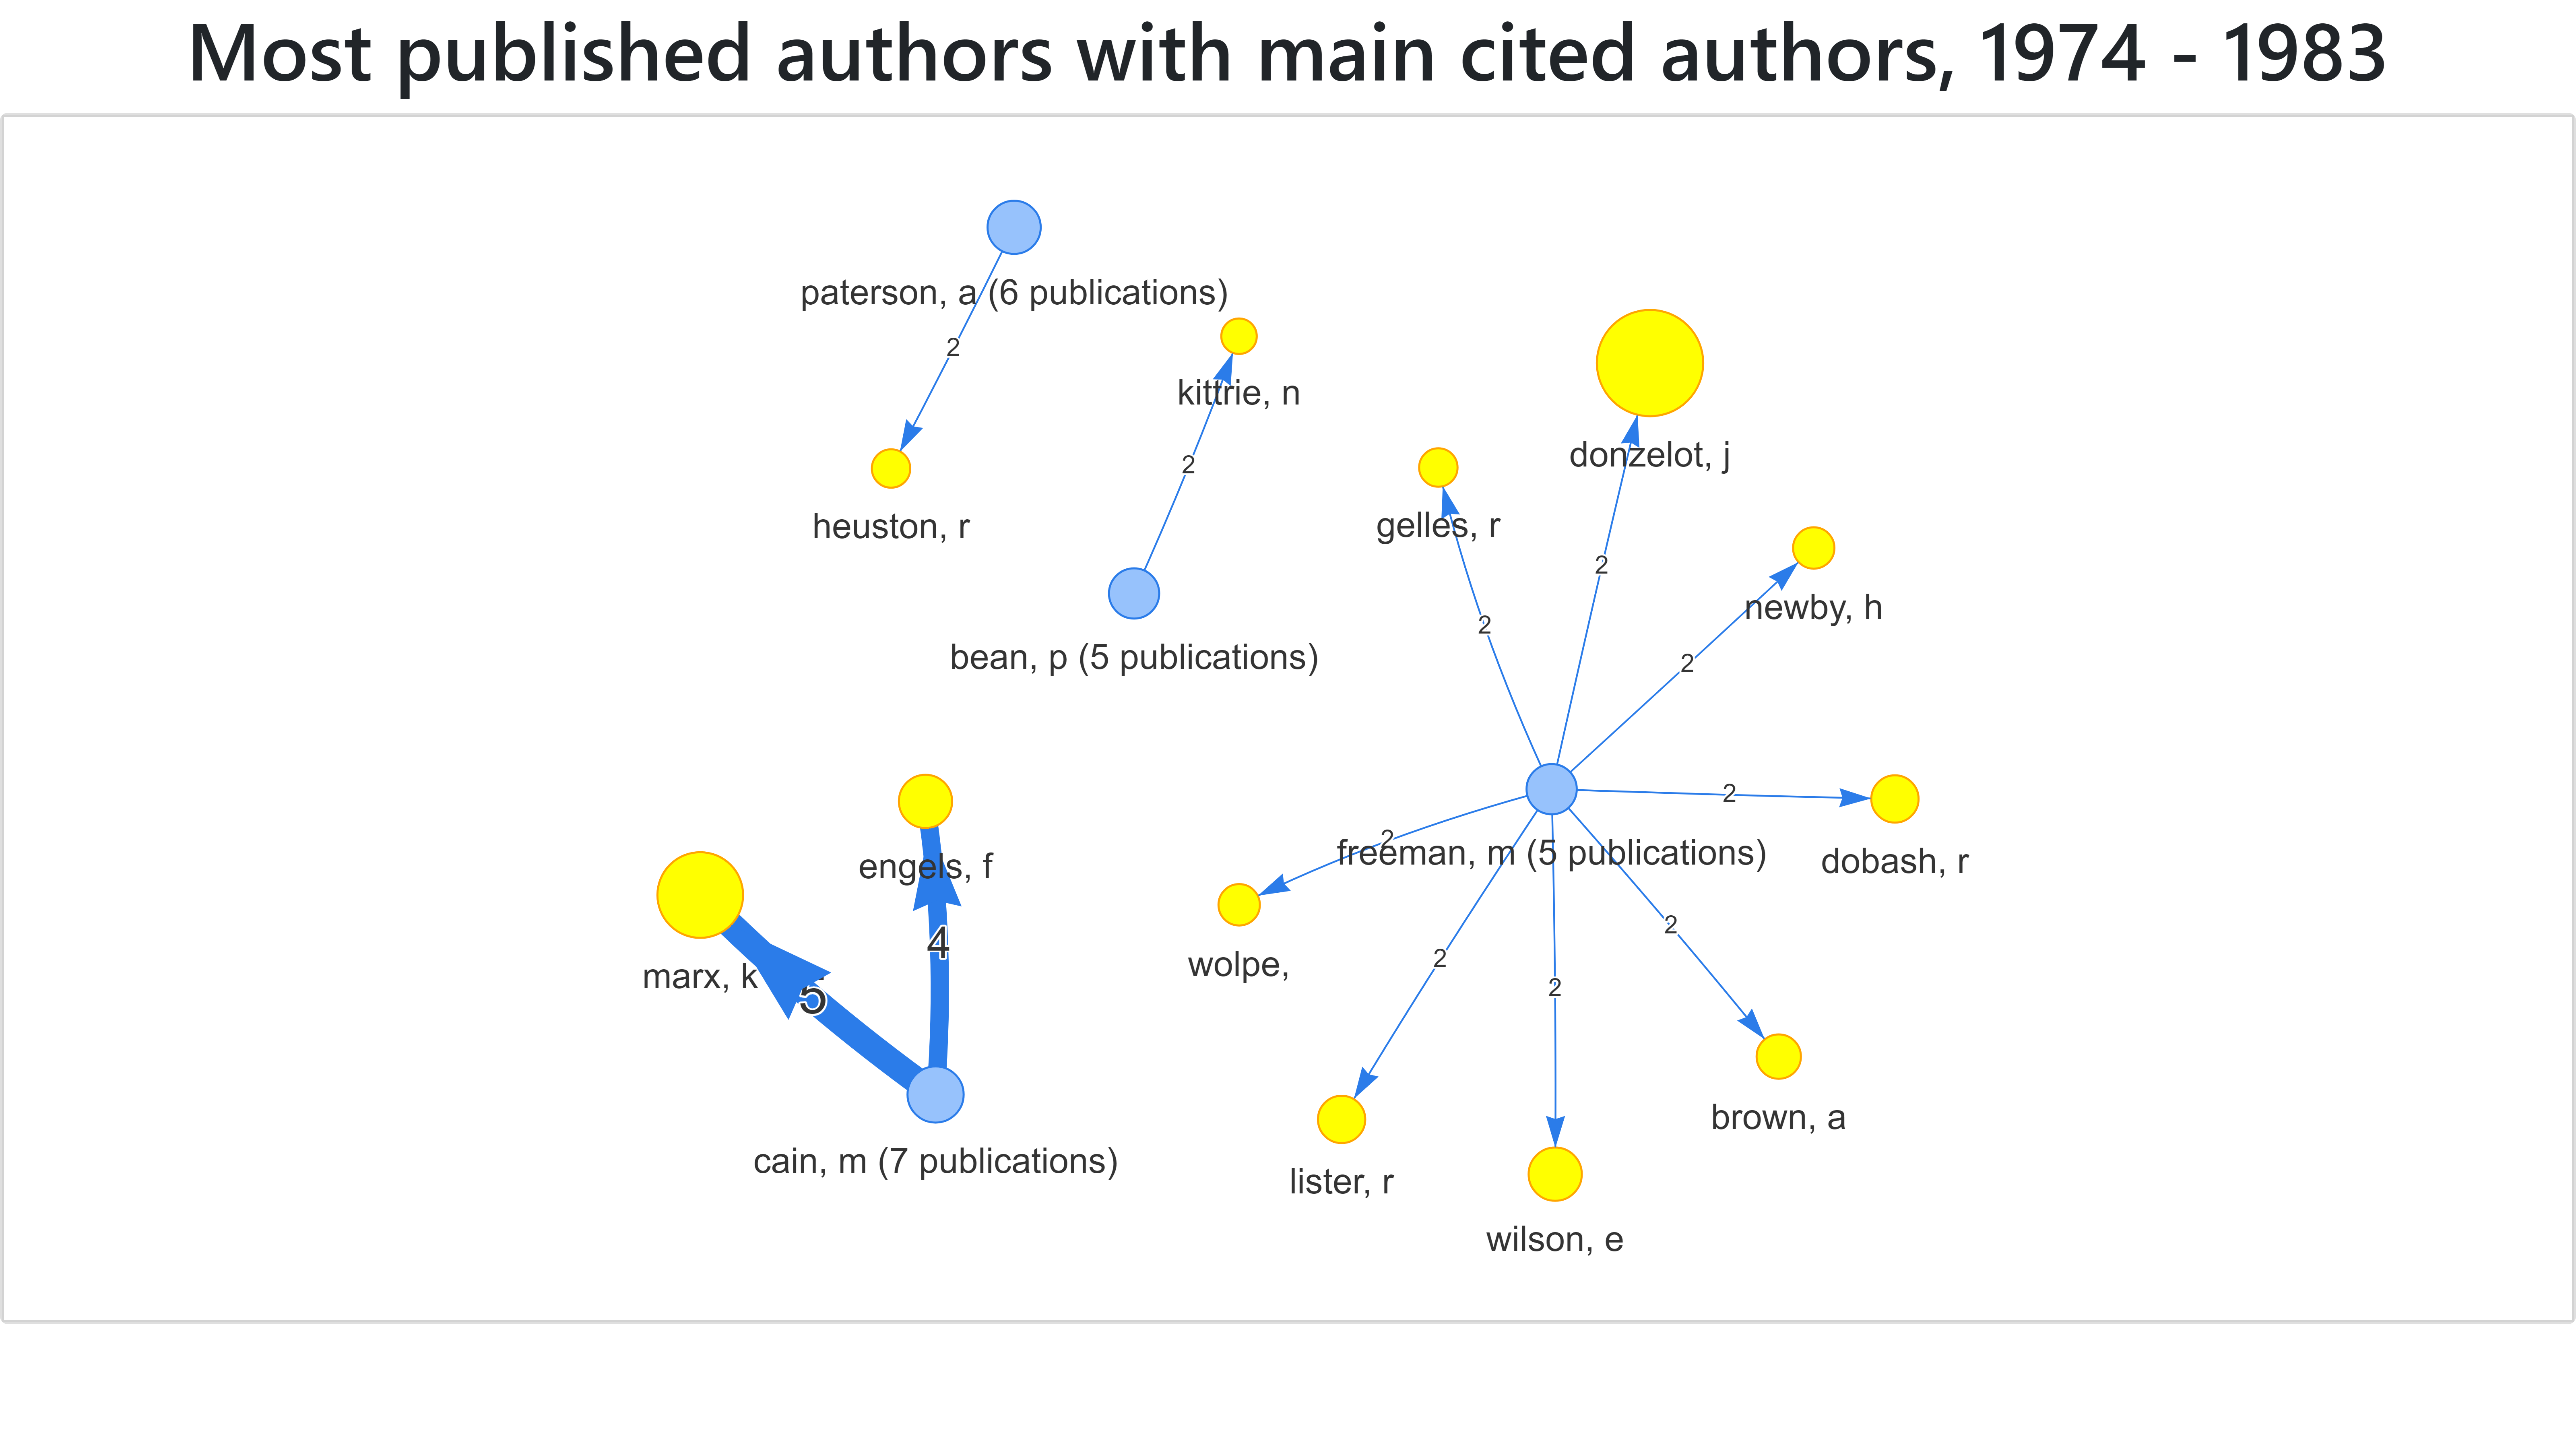

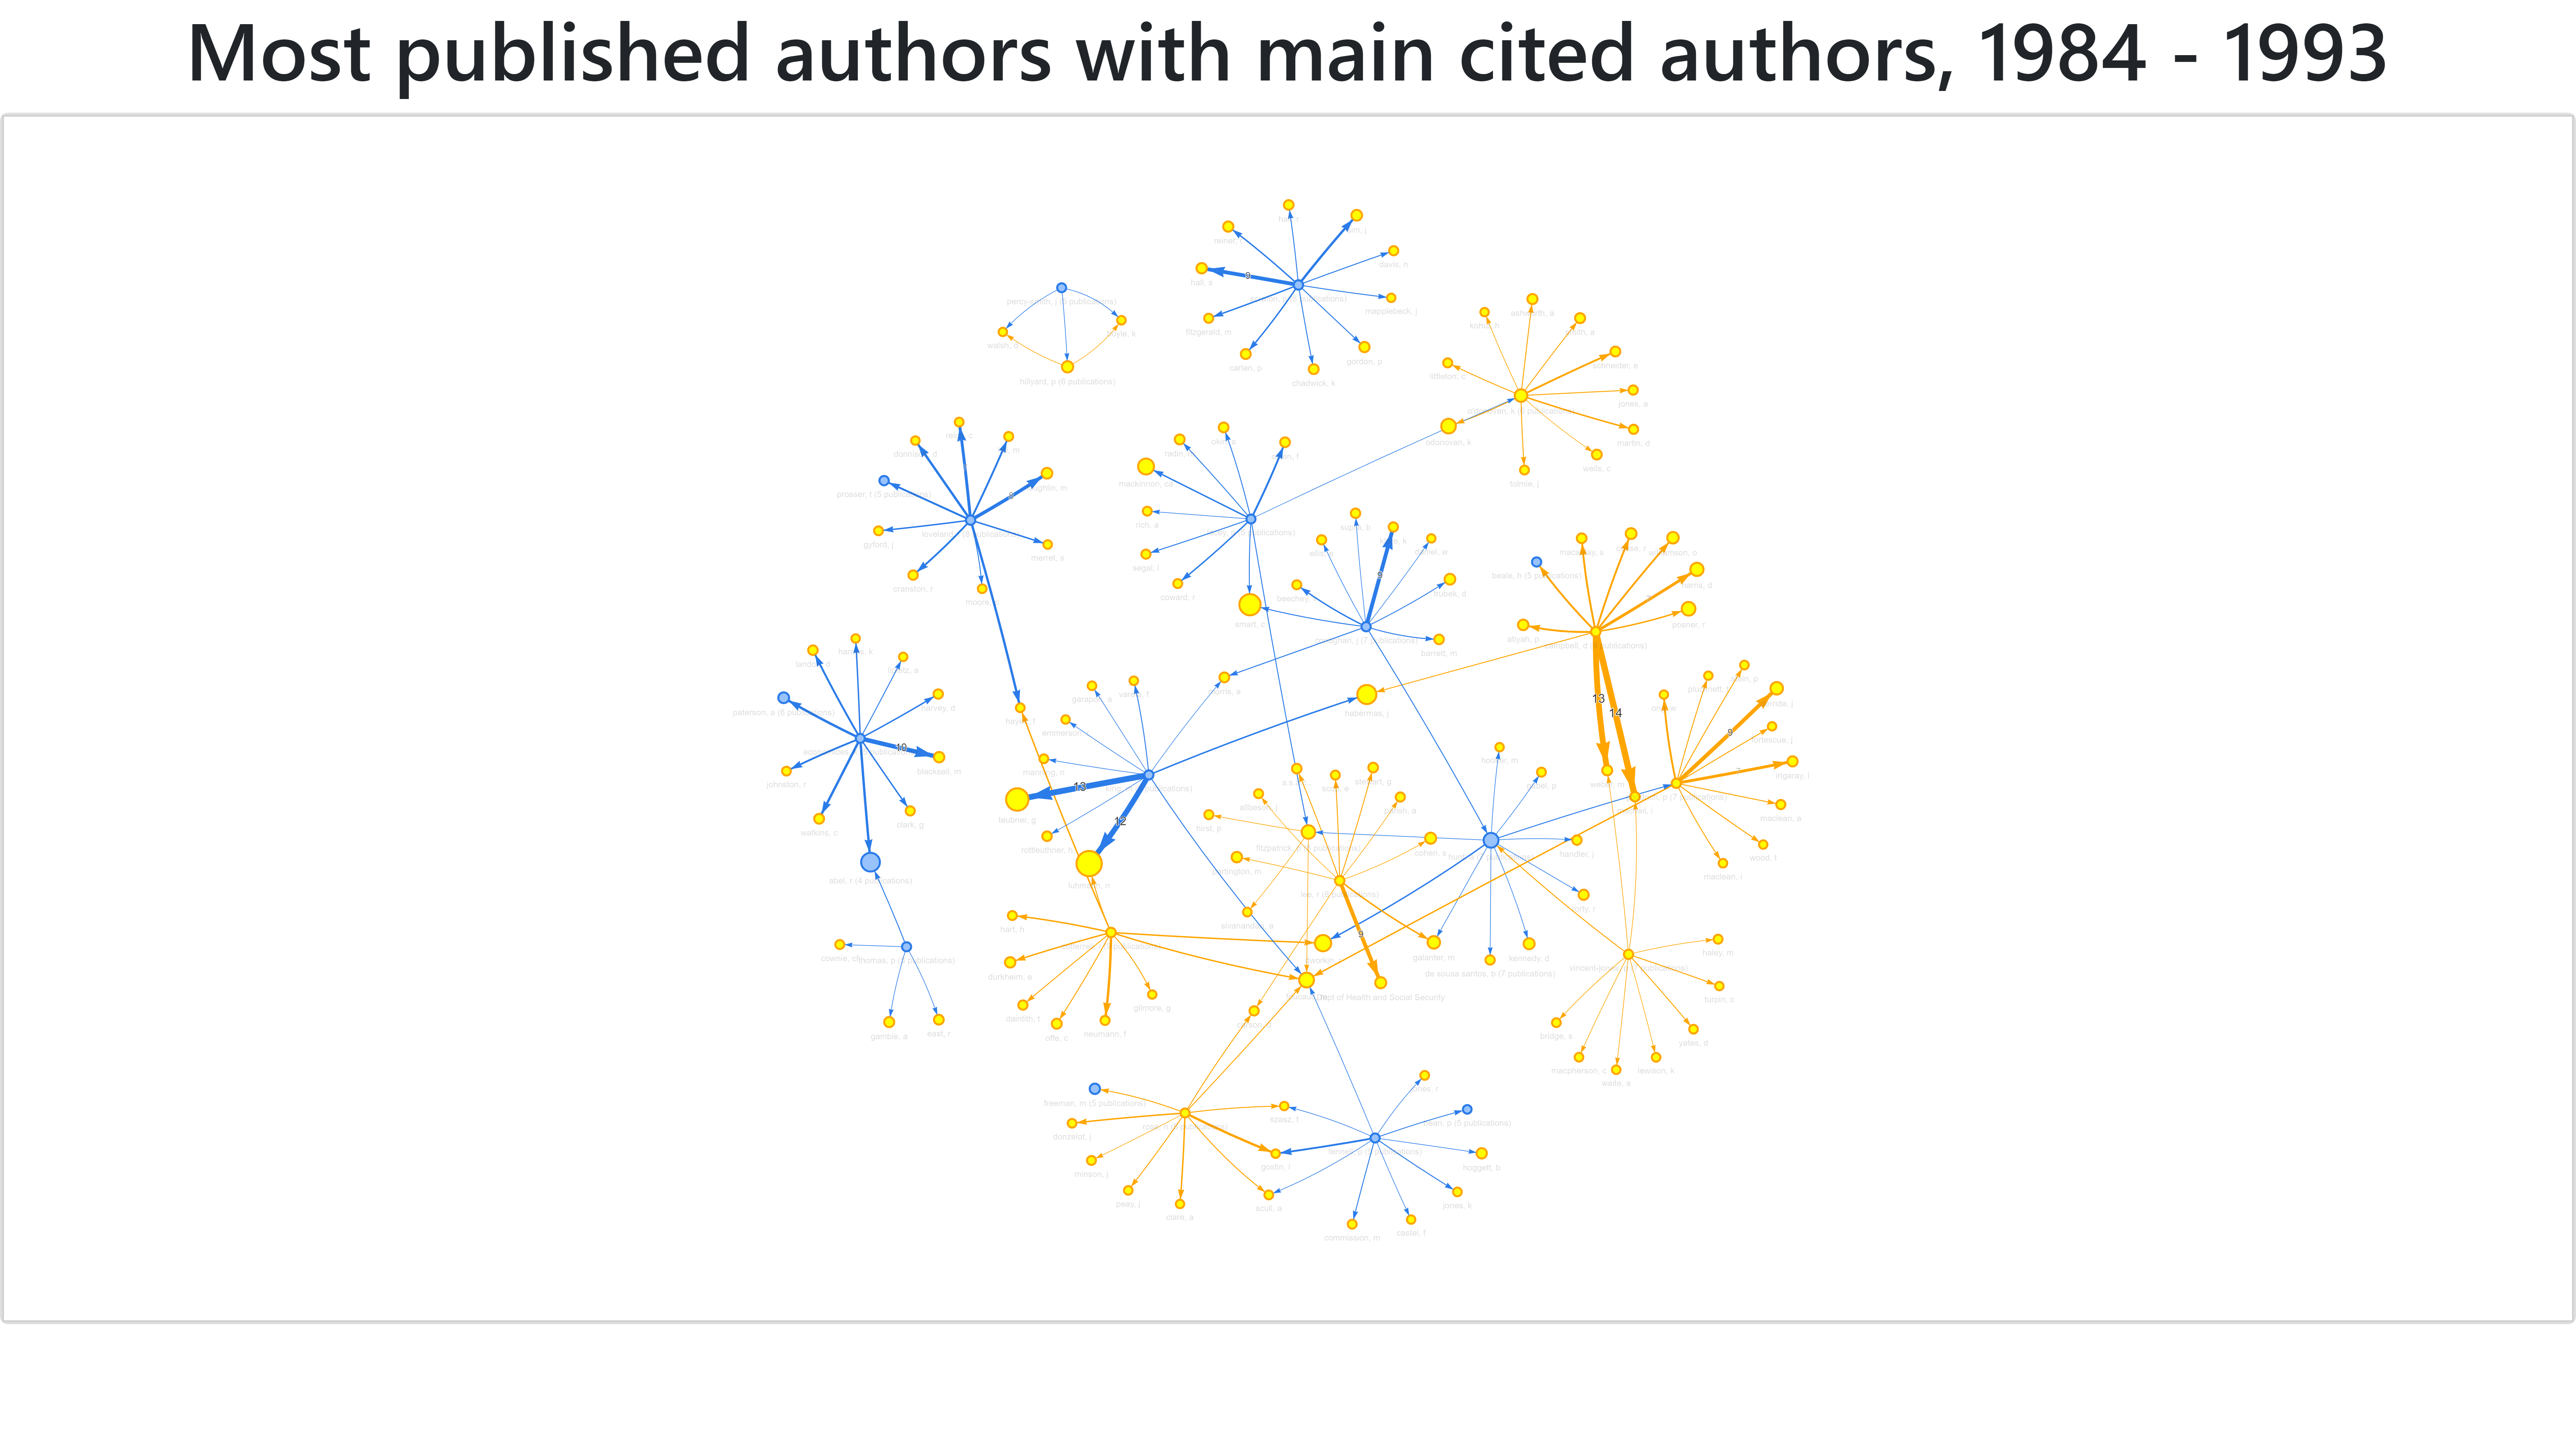

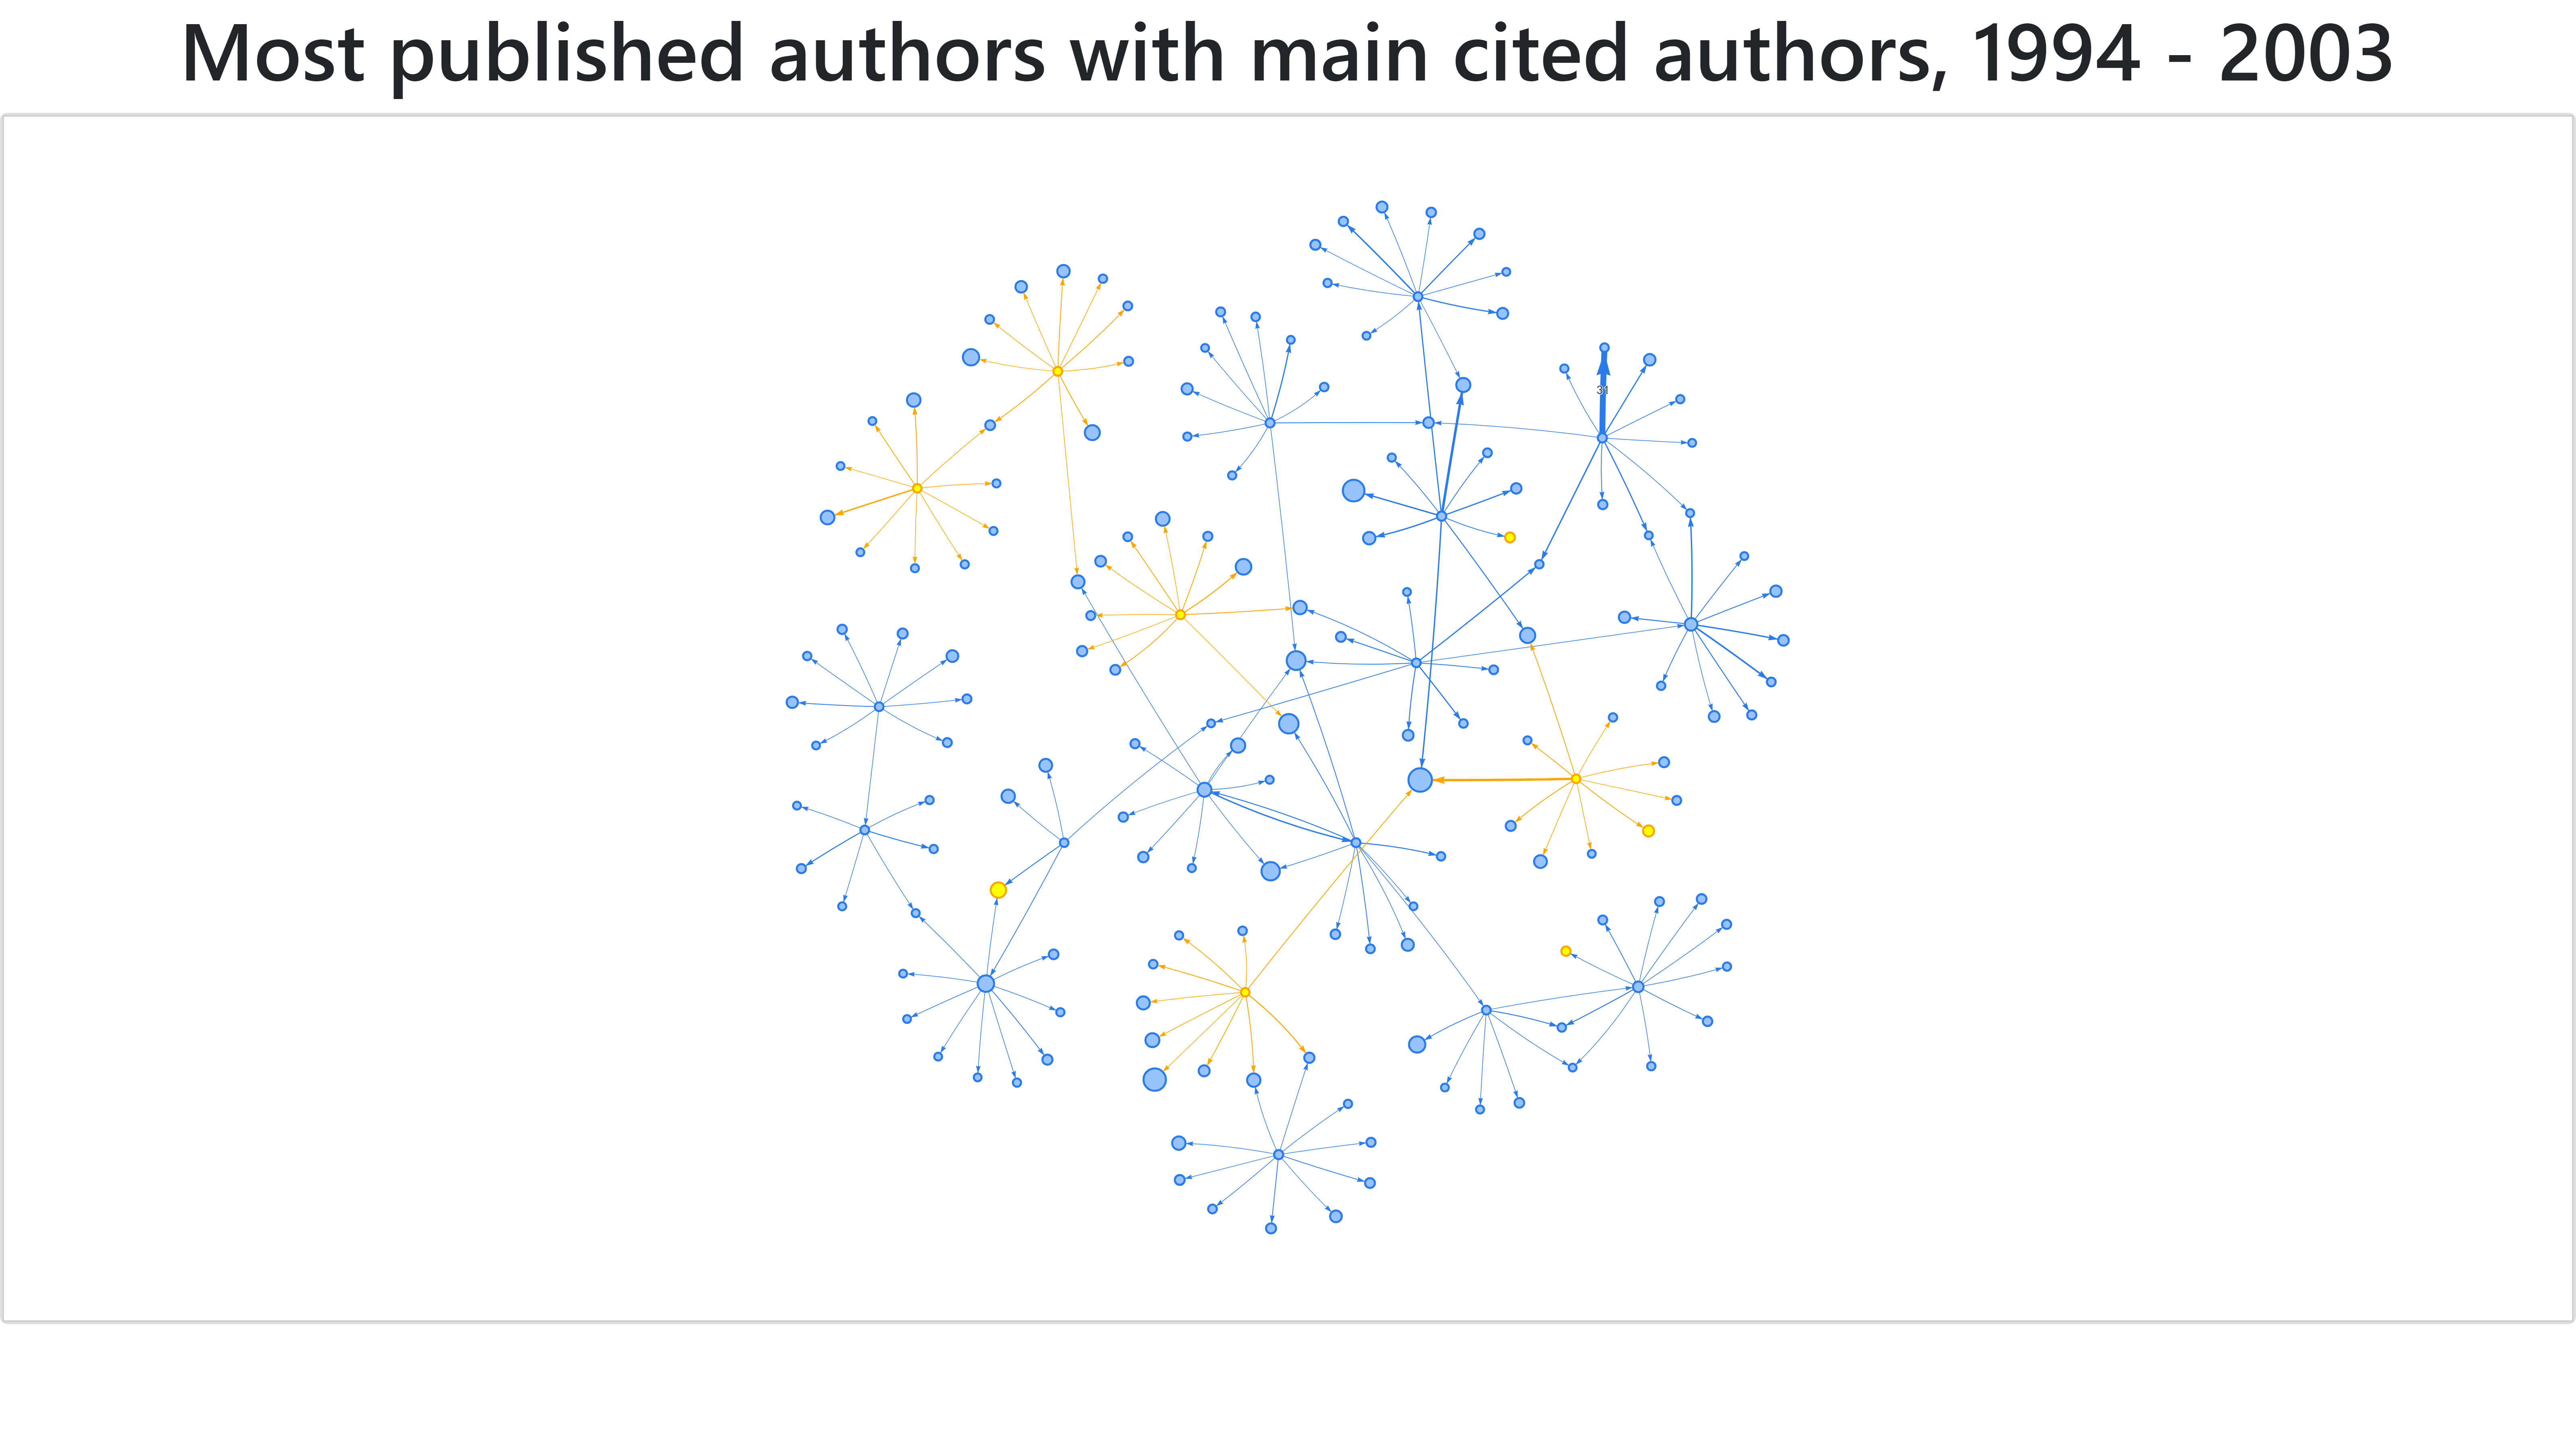

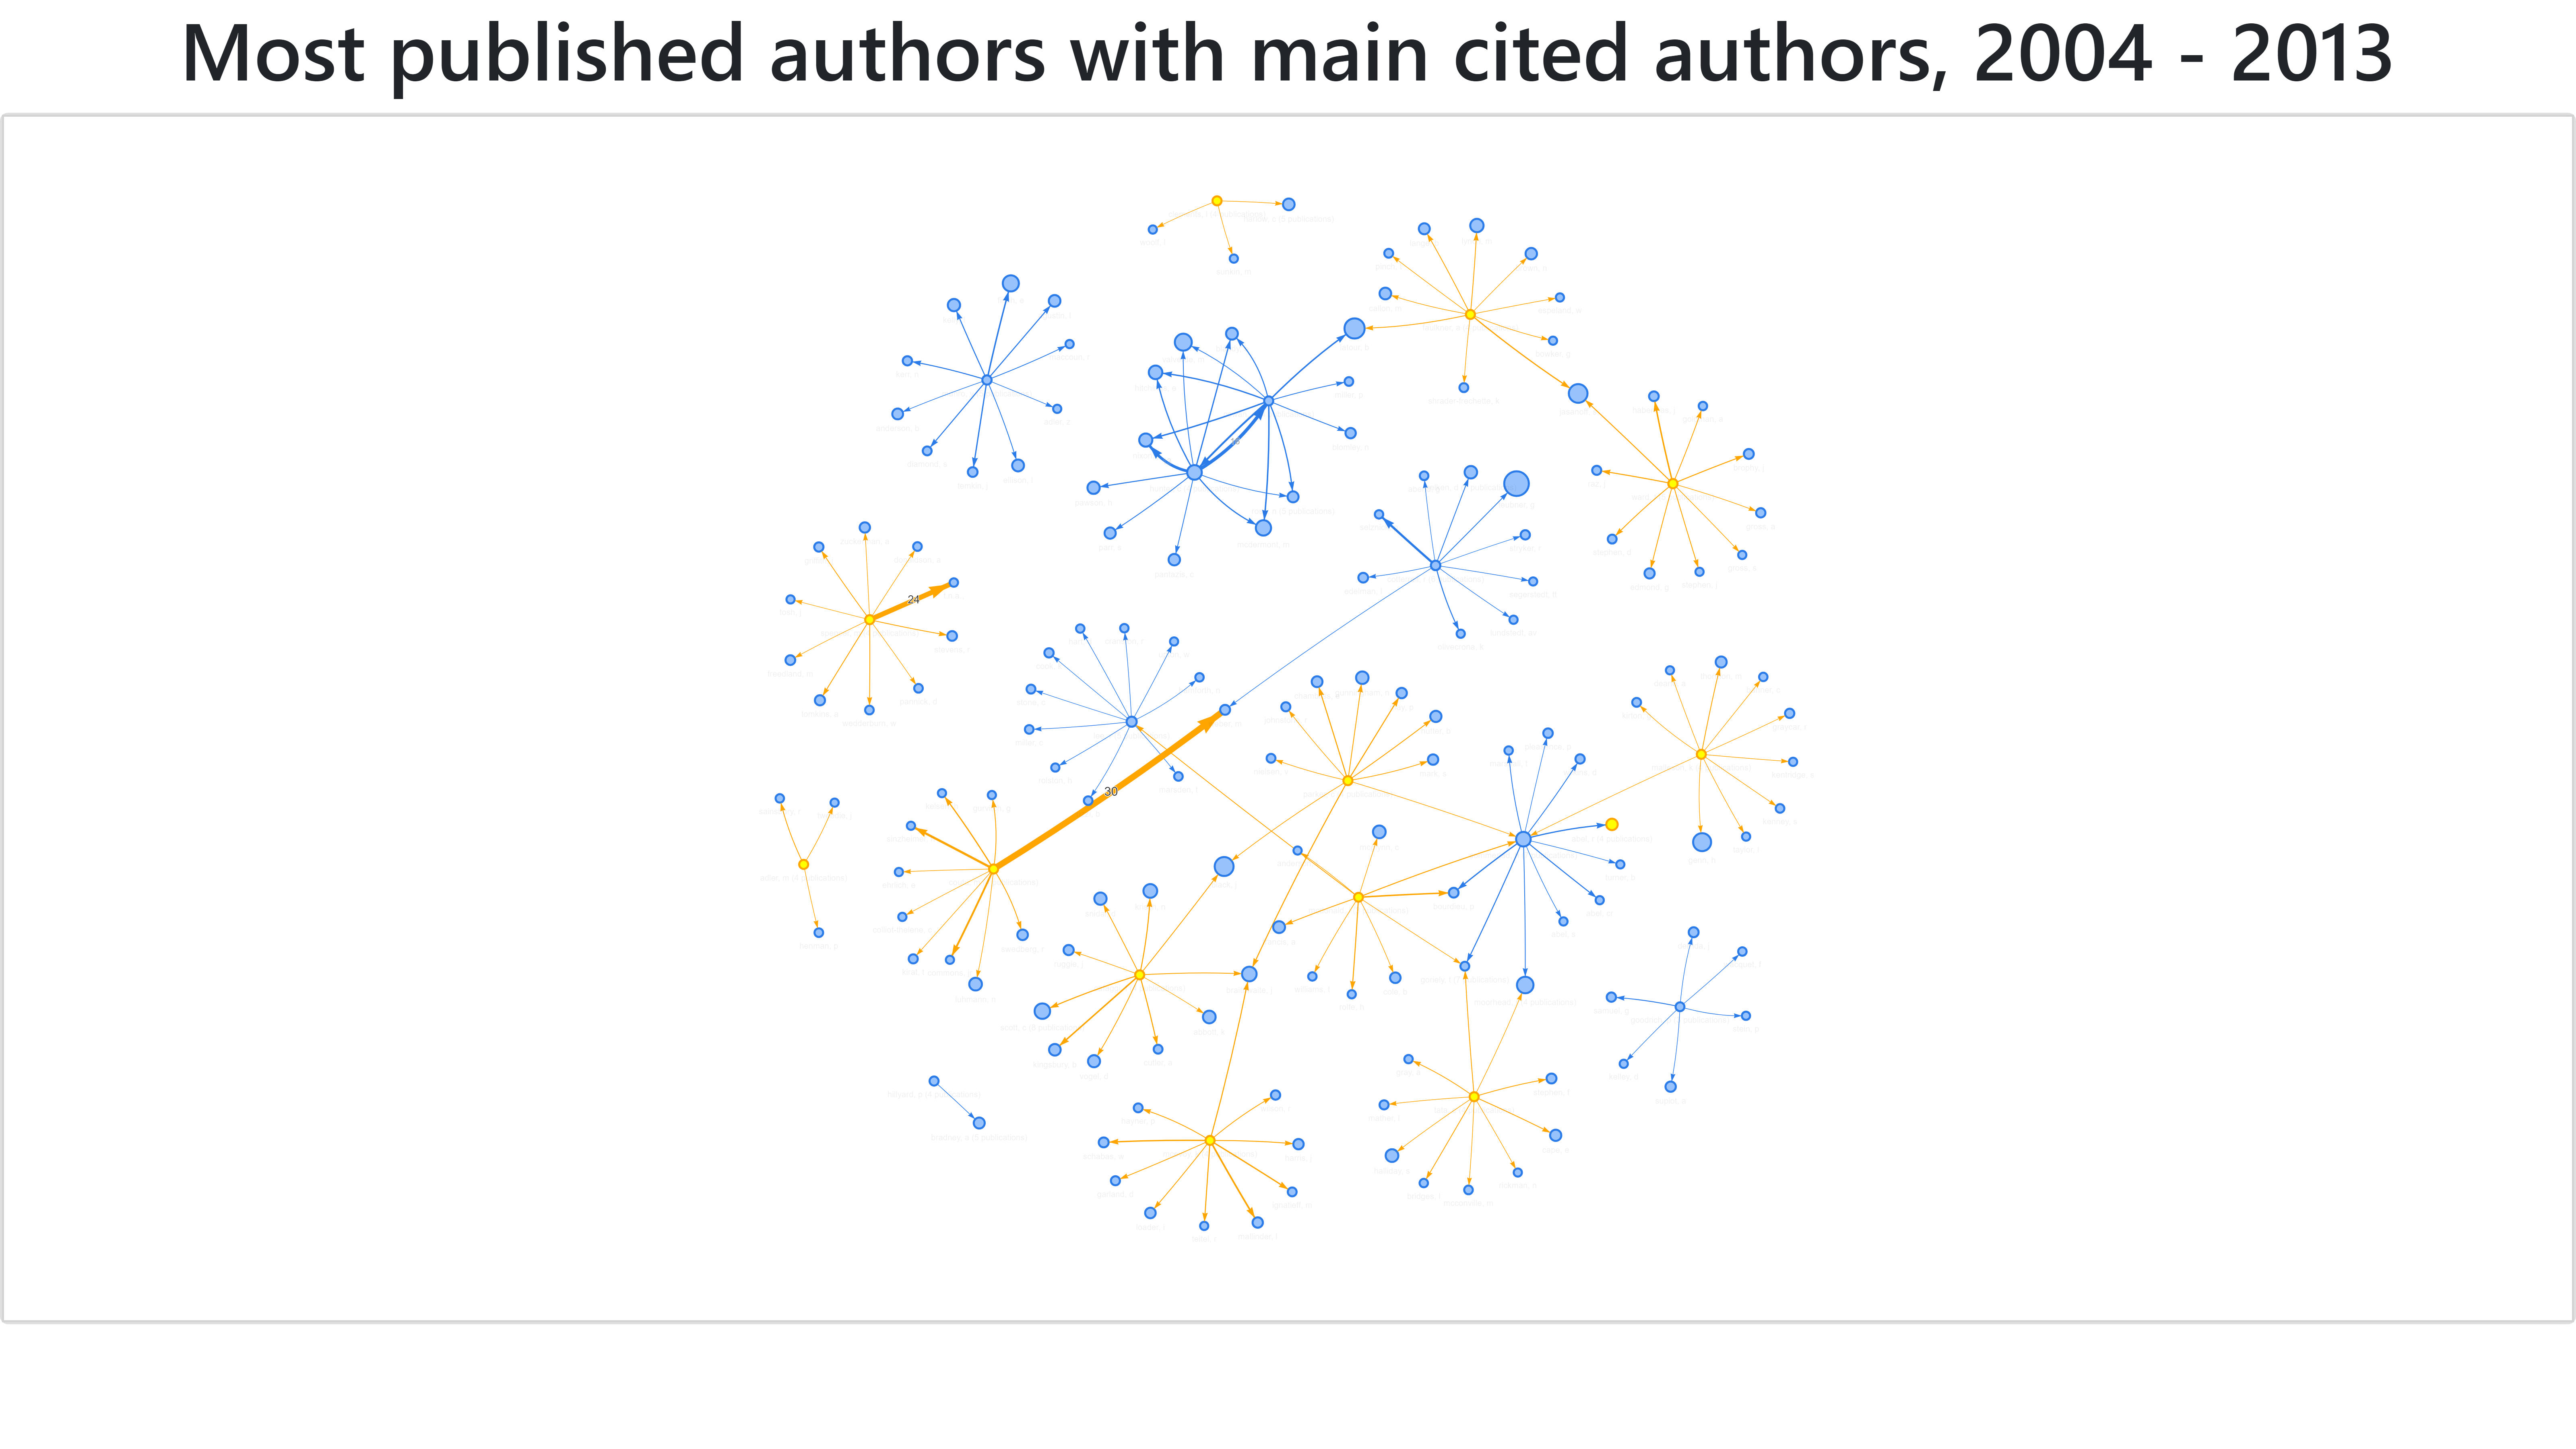

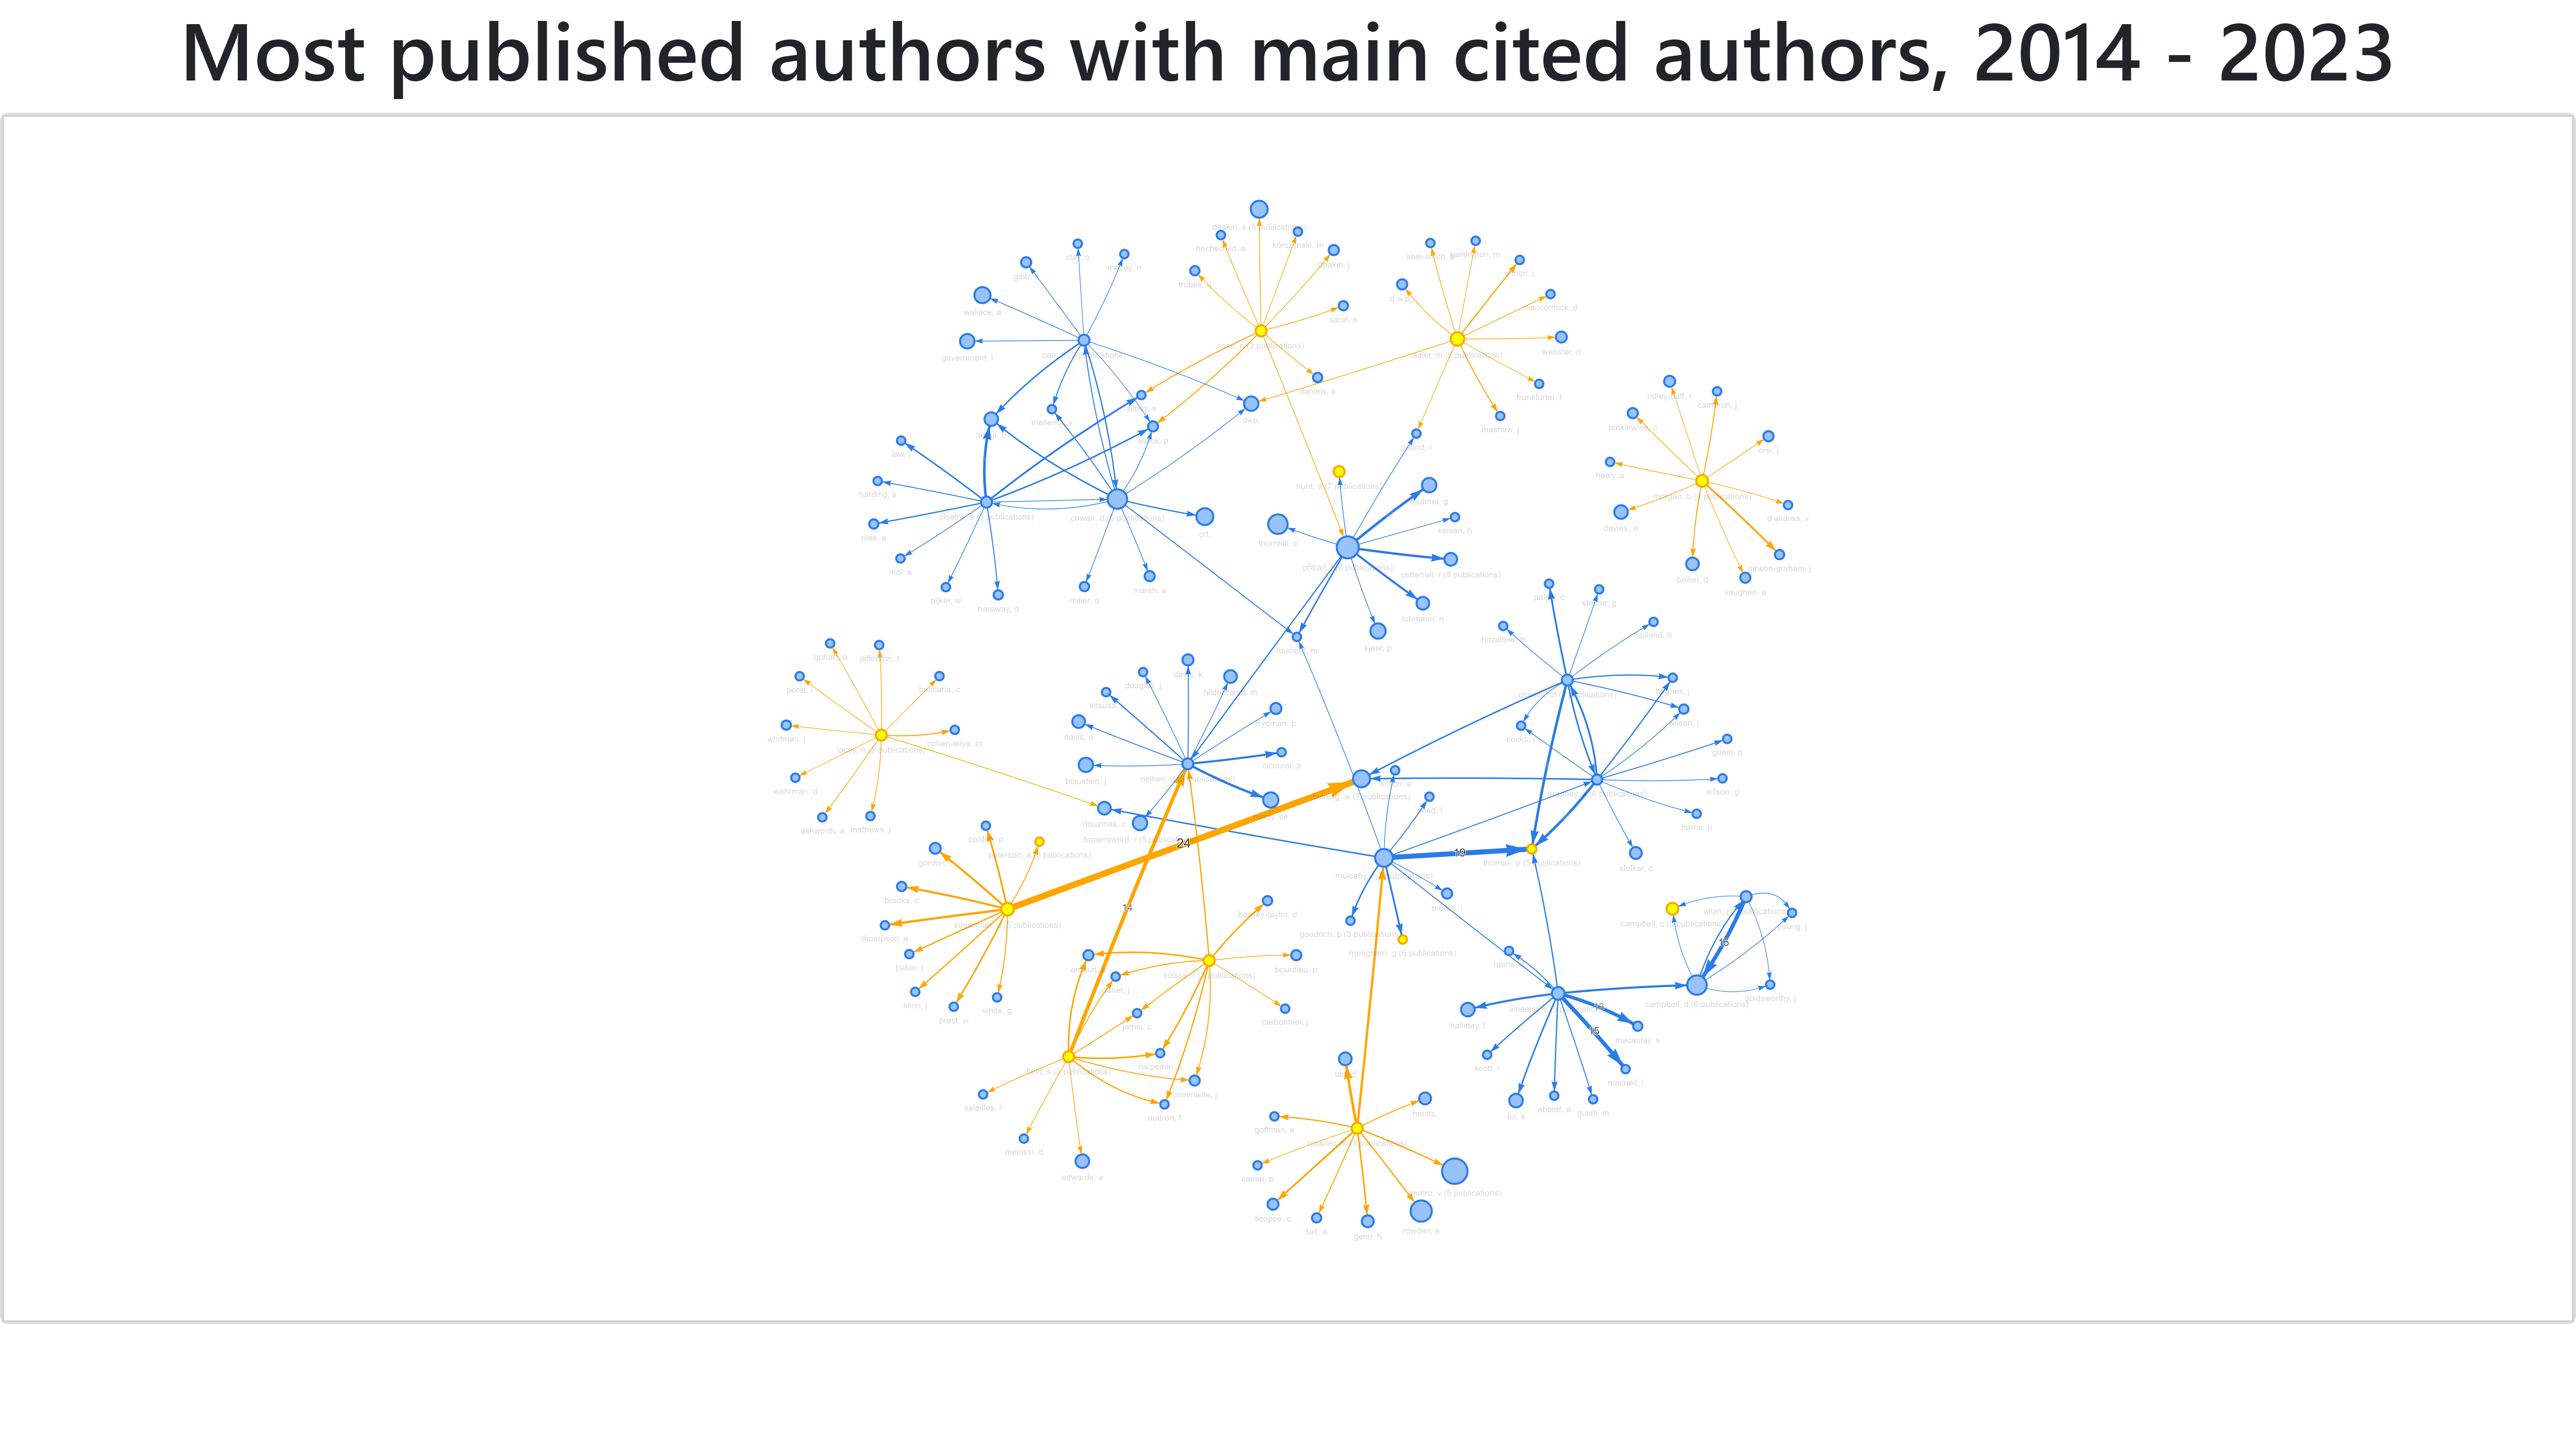

In [2]:
query = """
// find all authors who have published in the JLS in the given period, and use the 20 most-published ones
match (a1:Author)-[:CREATOR_OF]->(w:Work)
where a1.family <> "no_author"
    and w.year >= $year_start AND w.year <= $year_end
    and ((w)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'}) or (w)-[:PUBLISHED_IN]->(:Venue {id: 'br j law soc'}))
with a1, count(distinct w) as count
order by count desc
limit 20

// style the nodes to reflect the number of publications
set a1.vis_value = count
set a1.vis_group = "citingAuthor"
set a1.vis_label = (a1.display_name + "\n(" + toString(count) + " publications)")

// find the authors cited most by these most-published authors in their work in the given period
with a1
call {
    with a1
    match (a1)-[:CREATOR_OF]->(w1:Work)-[citation:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
    where a2.family <> "no_author"
        and w1.year >= $year_start AND w1.year <= $year_end
        and a1 <> a2
    with a2, count(citation) as citCount
    where citCount > 1
    with a2, citCount
    order by citCount desc
    limit 10
    with a2
    // size the cited author's node according to the total amount of citations of this author in the given period
    call {
        with a2
        optional match (a1:Author)-[:CREATOR_OF]->(:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(a2)
        where citedWork.year >= $year_start AND citedWork.year <= $year_end
            and a1 <> a2
        with a2, count(citation) as citationCount
        set a2.vis_value = citationCount
    }
    return a2
}
set a2.group = CASE WHEN exists(a2.group) THEN a2.group ELSE "citedAuthor" END
with a1, a2
match (a1)-[:CREATOR_OF]->(w1:Work)-[citation:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2)
where w1.year >= $year_start AND w1.year <= $year_end
    and ((w1)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'}) or (w1)-[:PUBLISHED_IN]->(:Venue {id: 'br j law soc'}))
with a1, a2, count(citation) as citationCount
return a1,
    apoc.create.vRelationship(a1, 'CITES', {value: citationCount, label:toString(citationCount)}, a2),
    a2
"""
from scripts.pyvis import create_timeseries, cleanup
from scripts.utils import get_graph
graph = get_graph("jls3")
# create high-resolution images
create_timeseries(graph, query,
                  min_edge_value=1,
                  file_prefix="docs/",
                  file_id="article-fig-05",
                  show_nav_bar=False,
                  screenshot=True,
                  title="Most published authors with main cited authors")
# create interactive version with navigation
create_timeseries(graph, query,
                  min_edge_value=1,
                  url="https://cboulanger.github.io/jls-bibliometry",
                  file_prefix="docs/",
                  file_id="article-fig-05-nav",
                  title="Most published authors with main cited authors",
                  caption="Network shows the 20 most published authors in the time period, with the 10  most-cited authors in their works. Node size reflects how much the authors are themselves cited in the given period. Source: JLS dataset")
cleanup(graph)